# MOLEARN ANALYSIS TUTORIAL

This tutorial is dedicated to demonstrating how to use the  neural network [molearn]() after it is trained, and how to characterize its performance. molearn is described in [ V.K. Ramaswamy et al. (2021). *Learning protein conformational space with convolutions and latent interpolations*, Physical Review X 11](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.011052). To get started, let's load some packages!

In [169]:
import sys, os, glob
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import modeller
from modeller import *
from modeller.scripts import complete_pdb

import biobox as bb

sys.path.insert(0, "C:\\Users\\xdzl45\\workspace\\molearn") #edit as required for your computer (or remove, if you installed molearn via conta-forge)
from molearn import load_data, Auto_potential, Autoencoder, ResidualBlock

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### 1. Load neural network and training set

Let's start by defining neural network file (variable `networkfile`, holding the parameters of a trained neural network), training set (variable `training_set_file`), and test set (variable `test_set_file`).

In [165]:
networkfile = "C:\\temp\\Dropbox\\Durham\\data\\neural_net\\conv1d-physics-path_B.pth"
training_set_file = "C:\\Users\\xdzl45\\workspace\\molearn\\test\\MurD_test.pdb"
test_set_file = "C:\\Users\\xdzl45\\workspace\\molearn\\test\\MurD_test.pdb"

Loading the training sets yields:
 - `training_set`, a data structure containing a desired subset of normalized atomic coordinates ready for submission to the neural network.
 - `meanval` and `stdval`, the original mean and standard deviation of this data, useful to rescale generated structures
 - `atom_names` list containing the names of atoms in the training set (in the same order)
 - `mol`, a  `biobox` instance corresponding to the coordinates in `training_set`, useful as a PDB writer and offering useful helper functions, e.g. RMSD calculation.
 - `test0` and `test1`, `biobox` instances of the two most extreme conformations by RMSD in the loaded dataset.

In [166]:
training_set, meanval, stdval, atom_names, mol, test0, test1 = load_data(training_set_file, atoms = ["CA", "C", "N", "CB", "O"], device=device)

Getting rmsd from file:  rmsd_matrix.npy
Conformations: (also saved to dataset_conformations.npy)
[]


`training_set` takes the form of a Nx3xM `Tensor` object, where N is the number of examples and M the number of atoms, and 3 the x, y, z coordinates of each atom. This is the order of dimensions required by the neural network, a typical multiPDB has columns in the NxMx3 order.

In [170]:
print(training_set.shape)

torch.Size([16, 3, 2145])


Let's now load a test set, but this time let's only retain the coordinates of atoms, normalised and ready to be submitted to the neural network. The test set must contain the same atoms as the training set, in the same order. The two datasets should also be aligned, since *molearn* is not rototranslation invariant (yet).

In [168]:
test_set = load_data(test_set_file, atoms = ["CA", "C", "N", "CB", "O"], device=device)[0]
print(test_set.shape)

Getting rmsd from file:  rmsd_matrix.npy
Conformations: (also saved to dataset_conformations.npy)
[]
torch.Size([16, 3, 2145])


We can now load the trained network. Note that the parameters passed to the `Autoencoder` costructor need to be the same as those used to build the trained neural network.

In [140]:
checkpoint = torch.load(networkfile, map_location=device)
network = Autoencoder(m=2.0, latent_z=2, r=2).to(device)
network.load_state_dict(checkpoint['model_state_dict'])

for modulelist in [network.encoder, network.decoder]:
    for layer in modulelist:
        if type(layer)==torch.nn.BatchNorm1d:
            layer.momentum=1.0
        elif type(layer)==ResidualBlock:
            for rlayer in layer.conv_block:
                if type(rlayer)==torch.nn.BatchNorm1d:
                    rlayer.momentum=1.0
                    
with torch.no_grad():
    network.decode(network.encode(training_set.float()))

network.eval()

Autoencoder(
  (encoder): ModuleList(
    (0): Conv1d(3, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
      )
    )
    (7): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=

### 2. Projection into latent space and back

Let's start by projecting the whole training set into the latent space.

In [141]:
with torch.no_grad():
    z = network.encode(training_set.float())

`z` is a (Nx2x1) `Tensor` object, featuring the projection in the latent space of each of the N examples in the training set. If this notebook is running with a computer with a GPU, it will be stored in its memory. To get the data so we can plot it, we should move it back to the CPU, and remove one dimension.

In [177]:
z_training = z.data.cpu().numpy()[:, :, 0]

`z` can be decoded back into structures that, hopefully, will closely resemble the training set. Note that we clip the output to the size of dataset's degrees of freedom (an extra padding is present).

In [182]:
with torch.no_grad():  
    decoded_training = network.decode(z)[:, :, :training_set.shape[2]]

`decoded_training` is a now `Tensor` object stored in the GPU with the same dimensionality as the input `training_set`, and features normalised atomic coordinates. While it can already be directly compared with `training_set`, to obtain an actual protein structure we can observe, we should reorder the columns, move the data onto the CPU and "un-normalise" them.

In [180]:
decoded_protein = decoded_training[:, :, :training_set.shape[2]].data.cpu().numpy().transpose(0, 2, 1)
print(decoded_protein.shape)

(16, 2145, 3)


Ok, we understood how this works, let's repeat encoding and decoding with the test set now!

In [142]:
with torch.no_grad():
    z = network.encode(test_set.float())
    z_test = z.data.cpu().numpy()[:, :, 0]
    decoded_test = network.decode(z)[:, :, :test_set.shape[2]]

### 2. dataset analysis

#### 2.2. RMSD (or MSE) of input vs autoencoded

A way to evaluate the performance of the network, is to compare protein conformations before they are submitted to the neural network, and after they get encoded and decoded. Please note that reporting such results for the training set only is poor practice, an independent test set should be submitted to evaluate the ability of the network to generalize beyond the examples provided for training. Let's calculate the MSE of both training and test sets!

In [146]:
def get_error(network, dataset, meanval, stdval, align=False, mol=""):
    '''
    Calculate the reconstruction error of a dataset encoded and decoded by a trained neural network
    '''

    z = network.encode(dataset.float())
    decoded = network.decode(z)[:,:,:dataset.shape[2]]
    
    err = []
    for i in range(dataset.shape[0]):

        crd_ref = dataset[i].permute(1,0).unsqueeze(0).data.cpu().numpy()*stdval + meanval
        crd_mdl = decoded[i].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :dataset.shape[2]]*stdval + meanval #clip the padding of models  

        if align: # use Molecule Biobox class to calculate RMSD
            mol.coordinates = deepcopy(crd_ref)
            mol.set_current(0)
            mol.add_xyz(crd_mdl[0])
            rmsd = mol.rmsd(0, 1)
        else:
            rmsd = np.sqrt(np.sum((crd_ref.flatten()-crd_mdl.flatten())**2)/crd_mdl.shape[1]) # Cartesian L2 norm

        err.append(rmsd)

    return np.array(err)
    
rmsd_training = get_error(network, training_set, meanval, stdval)
rmsd_test = get_error(network, test_set, meanval, stdval)

Time to produce two nice violin plots, reporting on the error of training and test set. Typically the latter should be slightly worse than the former, though ideally this difference should be as small as possible, indicating that the neural network can generalize well to structures it has never seen.

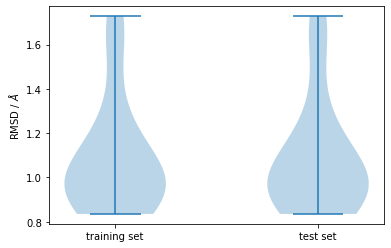

In [191]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([rmsd_training, rmsd_test])
ax.set_ylabel("RMSD / $\AA$")
ax.set_xticks([1, 2])
ax.set_xticklabels(["training set", "test set"]);

#### 2.3. DOPE score of input vs autoencoded

The DOPE score is a heuristic function used to estimate the energy of a protein conformation. It is used by software like Modeller to define whether a protein model is accurate. Here, we start by defining a function calculating the DOPE score of a PDB file.

In [149]:
def dope_score(fname):
    env = Environ()
    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')
    mdl = complete_pdb(env, fname)
    atmsel = Selection(mdl.chains[0])
    score = atmsel.assess_dope()
    return score

A positive value for a DOPE score indicates that the distriution of atoms is not what one should expect from a correct protein conformation. However, just looking at a negative value it is hard to tell "how good it is". To tell whether the models generated by the neural network are good, we will compare their DOPE score with the DOPE score of the input dataset. We now calculate the DOPE score of the loaded protein conformation dataset.

In [150]:
# set residues names with protonated histidines back to generic HIS name (needed by DOPE)
testH = mol.data["resname"].values
testH[testH == "HIE"] = "HIS"
testH[testH == "HID"] = "HIS"
mol.data["resname"] = testH

dope_dataset = []
dope_decoded = []
for i in range(decoded_training.shape[0]):

    # calculate DOPE score of training dataset
    crd_ref = training_set[i].permute(1,0).unsqueeze(0).data.cpu().numpy()*stdval + meanval
    mol.coordinates = deepcopy(crd_ref)
    mol.write_pdb("tmp.pdb")
    s = dope_score("tmp.pdb")
    dope_dataset.append(s)

    # calculate DOPE score of decoded counterpart
    crd_mdl = decoded_training[i].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :training_set.shape[2]]*stdval + meanval  
    mol.coordinates = deepcopy(crd_mdl)
    mol.write_pdb("tmp.pdb")
    s = dope_score("tmp.pdb")
    dope_decoded.append(s)
    

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633961
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629925
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641261
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630970
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633847
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625723
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636905
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

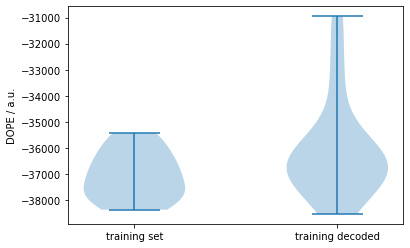

In [151]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([dope_dataset, dope_decoded])
ax.set_ylabel("DOPE / a.u.")
ax.set_xticks([1, 2])
ax.set_xticklabels(["training set", "training decoded"]);

### 4. full latent space characterization

In this section, we will grid sample the latent space. To this end, we start by identifying the region of interest defined by the coordinates of the training set projected into the latent space.

In [58]:
bx = (np.max(z_training[:, 0]) - np.min(z_training[:, 0]))*0.1 # 10% margins on x-axis
by = (np.max(z_training[:, 1]) - np.min(z_training[:, 1]))*0.1 # 10% margins on y-axis
xvals = np.linspace(np.min(z_training[:, 0])-bx, np.max(z_training[:, 0])+bx, 50)
yvals = np.linspace(np.min(z_training[:, 1])-by, np.max(z_training[:, 1])+by, 50)

#### 4.1. Evaluate re-encoding error

Each position in the latent space is decoded, then encoded, the decoded yet again. We assess the drift in latent space upon this iteration and the difference in two consecutive decoded structures with an L2 norm. This acts as a heuristic for the accuracy of the neural network: the smaller these numbers, the more accurate the network. 

In [59]:
surf_z = np.zeros((len(xvals), len(yvals))) # L2 norms in latent space ("drift")
surf_c = np.zeros((len(xvals), len(yvals))) # L2 norms in Cartesian space

with torch.no_grad():
    
    for x, i in enumerate(xvals):
        for y, j in enumerate(yvals):
    
            # take latent space coordinate (1) and decode it (2)
            z1 = torch.tensor([[[i,j]]]).float()
            s1 = network.decode(z1)[:,:,:training_set.shape[2]]
            
            # take the decoded structure, re-encode it (3) and then decode it (4)
            z2 = network.encode(s1)
            s2 = network.decode(z2)[:,:,:training_set.shape[2]]
            
            surf_z[x,y] = np.sum((z2.numpy().flatten()-z1.numpy().flatten())**2) # Latent space L2, i.e. (1) vs (3)
            surf_c[x,y] = np.sum((s2.numpy().flatten()-s1.numpy().flatten())**2) # Cartesian L2, i.e. (2) vs (4)
            
surf_c = np.sqrt(surf_c)
surf_z = np.sqrt(surf_z)

Plot error surfaces for L2 norms in the latent and Cartesian space, and compare the two. For visualisation purposes, we take the log of both quantities.

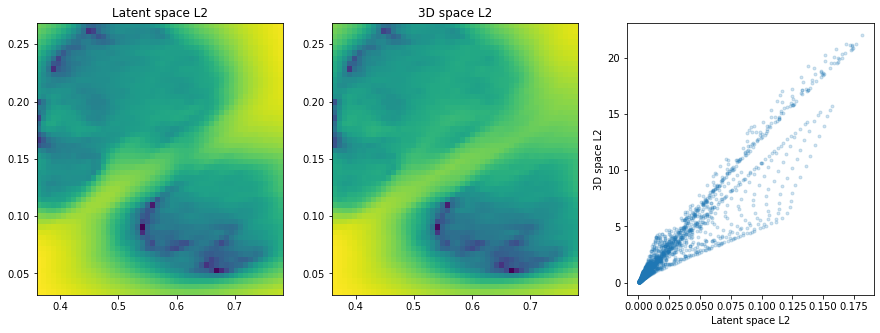

In [188]:
X, Y = np.meshgrid(xvals, yvals)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title("Latent space L2")
ax.pcolormesh(X, Y, np.log(surf_z))

ax = fig.add_subplot(1, 3, 2)
ax.set_title("3D space L2")
ax.pcolormesh(X, Y, np.log(surf_c))

ax = fig.add_subplot(1, 3, 3)
ax.set_xlabel("Latent space L2")
ax.set_ylabel("3D space L2")
ax.plot(surf_z.flatten(), surf_c.flatten(), ".", alpha=0.2);

You will notice that, although in general large drift corresponds to large RMSD, there is not a 1:1 relationship between the two quantities. This is because the latent space is not linear: the same magnitude of displacement in two different regions of the latent space may be associate to displacements of different magnitude in the Cartesian space. You may see several trends, overlayed, if the neural network has been trained with a collection of different molecular dynamics simulations projecting in different regions of the latent space.

#### 4.2. Evaluate DOPE score

We will now calculate the DOPE score of every conformation decoded from the latent space. Warning, this operation can take a *long* time, you can skip this part if you are in a rush!

In [61]:
surf_dope = np.zeros((len(xvals), len(yvals)))

with torch.no_grad():
    
    for x, i in enumerate(xvals):
        for y, j in enumerate(yvals):
    
            # take latent space coordinate (1) and decode it (2)
            z1 = torch.tensor([[[i,j]]]).float()
            s1 = network.decode(z1)[:,:,:training_set.shape[2]]
            
            crd_mdl = s1[0].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :training_set.shape[2]]*stdval + meanval  
            mol.coordinates = deepcopy(crd_mdl)
            mol.write_pdb("tmp.pdb")
            s = dope_score("tmp.pdb")
            surf_dope[x,y] = s

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3310    2498
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   548036
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MO



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3299    2859
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   609637
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3295    2920
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   615481
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2920
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   609694
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   614841
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2929
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   612201
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2797
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   600814
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3298     382
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):    95292
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  HIS:OXT  HIS
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MO

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences be

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   617201
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2983
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   612427
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2983
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   612009
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   614725
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   621691
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2582
Number of all, selected pseudo atoms           

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  ASP:OXT  ASP
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  MET:OXT  MET
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS
iatmcls_286W> MODEL atom not classified:

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  SER:OXT  SER
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3294    2728
Number of all, selected pseudo atoms           

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3292    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS       

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   613153
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   608523
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632266
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630783
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633055
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    3001
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   618281
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    3001
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628287
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2582
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   566774
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3295 

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected re

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   614314
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   608512
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630581
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628358
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627904
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630092
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636669
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647724
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3295    2524
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   537306
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   580876
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   573570
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2970
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   609132
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629779
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627406
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626010
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626328
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629563
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636903
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  THR:OXT  THR
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  PHE:OXT  PHE
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLU:OXT  GLU
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real a



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   580489
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   573886
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634804
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629457
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626803
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625262
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625243
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627110
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631370
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640019
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3291    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   580911
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   574472
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634761
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629623
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626509
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625504
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625289
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625869
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628438
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633776
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640343
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634036
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629184
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626285
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625371
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625470
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625626
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627401
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631135
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2728
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   578231
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639815
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633567
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628604
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626199
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625718
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625628
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625451
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626793
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629624
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2962
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   619103
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639740
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633260
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628374
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626490
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625825
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625930
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625608
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626412
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628942
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645341
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639826
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633552
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628287
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626715
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625757
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625830
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625877
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626649
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628629
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645502
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640458
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634007
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628367
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626899
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625821
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625733
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626232
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626698
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627987
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645494
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641278
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635315
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629321
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627090
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626278
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625761
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626110
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626777
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627715
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644905
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642019
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637129
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630632
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627440
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626556
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626026
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   625945
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626941
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627818
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643640
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642721
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638981
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632189
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628031
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627149
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626415
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626017
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626881
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628101
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642194
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642601
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640520
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633962
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629346
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627903
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626939
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626166
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626913
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628148
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640641
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642310
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641395
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635839
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631094
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628401
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627413
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626467
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626974
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628379
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638926
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641378
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641755
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637409
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632745
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629090
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627694
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626938
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   626992
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628644
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637397
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639965
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641599
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638656
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634188
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629998
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627660
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627175
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627139
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628960
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635958
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638711
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640889
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639285
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635618
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630940
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627977
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627636
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627528
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629165
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634707
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637082
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639634
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639678
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636575
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632111
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628565
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627998
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627989
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629564
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633626
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635807
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638540
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639781
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637350
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633241
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629086
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628167
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628500
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629903
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632928
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634876
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637823
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639350
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637811
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633991
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629982
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628395
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629085
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630153
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632384
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634331
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636797
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638117
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637323
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634643
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631129
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628862
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629399
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630601
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632173
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634069
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635992
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637139
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636700
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635043
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632206
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629929
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629622
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631255
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631981
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635302
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636751
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636153
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635038
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632975
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630936
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630300
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631792
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631896
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634191
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635469
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635920
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635664
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635153
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634114
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632149
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631160
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632405
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631562
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634780
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636182
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635519
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634742
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635034
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634824
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633182
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632346
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633175
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631176
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634954
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636681
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635153
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634364
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634789
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635587
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634350
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633599
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634174
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631194
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634259
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636546
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634706
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633949
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634699
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635399
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635262
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634628
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635075
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631367
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633135
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635227
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633766
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633372
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634272
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635096
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636055
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635858
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635956
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631473
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631786
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632913
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632633
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632507
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635003
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636390
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637129
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637339
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631047
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630663
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630317
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631181
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632075
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633746
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635273
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636495
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637830
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638460
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630518
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629325
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628479
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630169
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631923
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633929
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635679
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636889
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638520
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639661
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630102
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628511
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627954
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629670
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631717
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634475
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   637381
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639094
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640565
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629539
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627869
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627662
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629224
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631645
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635134
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636826
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638440
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640246
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641631
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628879
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627415
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627691
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629267
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631454
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635358
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638082
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639443
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641539
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642784
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628693
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627283
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627665
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629235
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631195
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635355
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638717
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640548
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642965
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644353
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629218
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627189
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627876
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629245
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631338
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635071
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   638837
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641465
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644354
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645915
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630179
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627143
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628081
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629587
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631837
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635097
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639204
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   642501
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645821
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648023
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631503
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   627757
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628264
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629847
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632599
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635388
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639574
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   643606
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647157
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   650116
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632652
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628975
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   628540
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630263
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633117
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635917
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639986
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644609
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648433
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   652045
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633399
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630128
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629028
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630482
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633446
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636369
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640384
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   645475
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649846
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   654314
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633650
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630531
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   629834
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630511
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633681
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636774
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   640677
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   646627
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   651271
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   656518
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634449
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630582
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630422
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630894
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633739
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636772
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641203
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   647356
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   653211
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2606
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (exc

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635594
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630885
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630522
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631263
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633464
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636449
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641444
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648048
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   654679
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2606
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (exc

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636883
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631473
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630870
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631890
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632985
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635926
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641851
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648960
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2570
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   556662
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2570
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   561813
Dynamic pairs routine                             : 5, N

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   639015
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632499
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631632
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632720
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635780
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641852
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649814
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2570
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   557654
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   644632
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635560
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632553
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633670
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633805
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635782
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641154
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   649109
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3288    2428
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                  

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  PRO:OXT  PRO
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real a

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3289    2717
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   577063
D

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3287    2889
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   601023
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts up

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634712
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   634346
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   635023
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636554
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641217
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   648921
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3290     978
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number 



>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3293     963
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   243822
Dynamic pairs routine                             : 5, NATM_SEL x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                                         :       15
CONTACT_SHELL                                     :   15.000
DYNAMI

read_to_681_> topology.submodel read from topology file:        3
relabel_387W> Model has multiple chains, and they do not all have a unique
              chain ID. Suggest you relabel them as A, B, C, etc.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  ARG:OXT  ARG
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  VAL:OXT  VAL
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLN:OXT  GLN
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  LEU:OXT  LEU
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
iatmcls_286W> MODEL atom not classified:  ALA:OXT  ALA
iatmcls_286W> MODEL atom not classified:

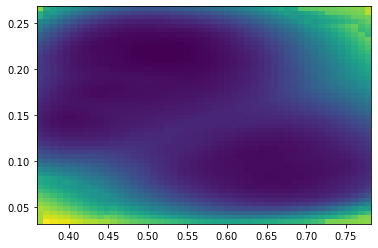

In [62]:
x, y = np.meshgrid(xvals, yvals)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh(x, y, surf_dope);

***

## 5. Display data via interactive plot

Let's start by defining some helper functions!

In [128]:
def oversample(crd, pts=10):
    '''
    add extra equally spaced points between a list of points ("pts" per interval)
    ''' 
    pts += 1
    steps = np.linspace(1./pts, 1, pts)
    pts = [crd[0,0]]
    for i in range(1, len(crd[0])):
        for j in steps:
            newpt = crd[0, i-1] + (crd[0, i]-crd[0, i-1])*j
            pts.append(newpt)
    
    return np.array([pts])

def generate(network, crd, stdval, meanval):
    '''
    generate a collection of protein conformations, given (Nx2) coordinates in the latent space
    ''' 
    with torch.no_grad():
        z = torch.tensor(crd.transpose(1, 2, 0)).float()   
        s = network.decode(z)[:, :, :training_set.shape[2]].numpy().transpose(0, 2, 1)
    
    return s*stdval + meanval

The big block of code that follows is a graphical user interface to navigate the landscape of the neural network (work in progress).

In [153]:
from ipywidgets import HBox, VBox, Layout
from ipywidgets import widgets
from tkinter import Tk, filedialog
import plotly.graph_objects as go
import nglview as nv
import warnings
warnings.filterwarnings("ignore")
import time

# create an MDAnalysis instance of input protein
import MDAnalysis as mda
mol.write_pdb("tmp.pdb")
mymol = mda.Universe('tmp.pdb')

def on_click(trace, points, selector):
    '''
    control display of training set
    ''' 
    
    global waypoints
    
    # add new waypoint to list
    pt = np.array([[points.xs[0], points.ys[0]]])
    if len(waypoints) == 0:
        waypoints = pt    
    else:
        waypoints = np.concatenate((waypoints, pt))     

    # update latent space plot
    latent.data[1].x = waypoints[:, 0]
    latent.data[1].y = waypoints[:, 1]
    latent.update()

    # update textbox (triggering update of 3D representation)
    try:
        pt = np.array([latent.data[1].x, latent.data[1].y]).T.flatten().round(decimals=4).astype(str)
        mybox.value = " ".join(pt)
    except:
        return

def interact_3D(mybox, samplebox):
    '''
    generate and display proteins according to latent space trail
    ''' 
    
    # get latent space path
    try:
        crd = np.array(mybox.split()).astype(float)
        crd = crd.reshape((1, int(len(crd)/2), 2))       
        crd = oversample(crd, pts=int(samplebox))
    except:
        button_pdb.disabled = False
        return 
    
    # generate structures along path
    t = time.time()
    gen = generate(network, crd, stdval, meanval)
    print(f'{crd.shape[1]} struct. in {time.time()-t:.4f} sec.')
    
    # display generated structures
    mymol.load_new(gen)
    view = nv.show_mdanalysis(mymol)
    view.add_representation("spacefill")
    display(view)
    
    button_pdb.disabled = False

    
def drop_background_event(change):
    '''
    control colouring style of latent space surface
    '''
    
    global surf_c
    global surf_z
    global surf_dope
    
    state_choice = change.new
        
    if change.new == "drift":
        latent.data[0].z = np.log(surf_z)
        latent.data[0].zmin = np.min(sz)
        latent.data[0].zmax = np.max(sz)
        block0.children[1].min = np.min(sz)
        block0.children[1].max = np.max(sz)
        block0.children[1].value = (np.min(sz), np.max(sz))
        block0.children[1].readout_format = '.1f'
        
    elif change.new == "RMSD":
        latent.data[0].z = np.log(surf_c)
        latent.data[0].zmin = np.min(sc)
        latent.data[0].zmax = np.max(sc)
        block0.children[1].min = np.min(sc)
        block0.children[1].max = np.max(sc)
        block0.children[1].value = (np.min(sc), np.max(sc))
        block0.children[1].readout_format = '.1f'
        
    elif change.new == "DOPE":
        latent.data[0].z = surf_dope.T
        latent.data[0].zmin = np.min(surf_dope)
        latent.data[0].zmax = np.max(surf_dope)
        block0.children[1].min = np.min(surf_dope)
        block0.children[1].max = np.max(surf_dope)
        block0.children[1].value = (np.min(surf_dope), np.max(surf_dope))
        block0.children[1].readout_format = 'd'
    
    latent.update()


def check_training_event(change):
    '''
    control display of training set
    ''' 
    state_choice = change.new
    latent.data[2].visible = state_choice
    latent.update()

    
def range_slider_event(change):
    '''
    update surface colouring upon manipulation of range slider
    '''
    latent.data[0].zmin = change.new[0]
    latent.data[0].zmax = change.new[1]
    latent.update()
    

def mybox_event(change):
    '''
    control manual update of waypoints
    '''
    
    global waypoints
    
    try:
        crd = np.array(change.new.split()).astype(float)
        crd = crd.reshape((int(len(crd)/2), 2))
    except:
        button_pdb.disabled = False
        return
    
    waypoints = crd.copy()

    latent.data[1].x = waypoints[:, 0]
    latent.data[1].y = waypoints[:, 1]
    latent.update()
    
    
def button_pdb_event(check):
    '''
    save PDB file corresponding to the interpolation shown in the 3D view
    '''
    
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    fname = filedialog.asksaveasfilename(defaultextension="pdb", filetypes=[("PDB file", "pdb")])
    
    if fname == "":
        return
    
    crd = np.array(mybox.value.split()).astype(float)
    crd = crd.reshape((1, int(len(crd)/2), 2))       
    crd = oversample(crd, pts=int(samplebox.value))
    
    gen = generate(network, crd, stdval, meanval)
    mymol.load_new(gen)
    protein = mymol.select_atoms("all")

    with mda.Writer(fname, protein.n_atoms) as W:
        for ts in mymol.trajectory:
            W.write(protein)    


#####################################################

# collection of all saved waypoints
waypoints = []

# surface representation menu
drop_background = widgets.Dropdown(
    options=['drift', 'RMSD', 'DOPE'],
    value='drift',
    description='Surf.:',
    disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

drop_background.observe(drop_background_event, names='value')

# training set visualisation menu
check_training = widgets.Checkbox(
    value=False,
    description='show training',
    disabled=False,
    indent=False, layout=Layout(flex='1 1 0%', width='auto'))

check_training.observe(check_training_event, names='value')

# text box holding current coordinates
mybox = widgets.Textarea(value='Welcome',
                         placeholder='coordinates',
                         description='crds:',
                         disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

mybox.observe(mybox_event, names='value')

samplebox = widgets.Text(value='10',
                         description='sampling:',
                         disabled=False, layout=Layout(flex='1 1 0%', width='auto'))


button_pdb = widgets.Button(
    description='Save PDB',
    disabled=True, layout=Layout(flex='1 1 0%', width='auto'))

button_pdb.on_click(button_pdb_event)

range_slider = widgets.FloatRangeSlider(
    value=[np.min(sc), np.max(sc)],
    min=np.min(sc),
    max=np.max(sc),
    step=(np.max(sc)-np.min(sc))/100.0,
    description='cmap range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f', layout=Layout(flex='1 1 0%', width='auto'))

range_slider.observe(range_slider_event, names='value')

### latent space plot ### 

# coloured background
sc = np.log(surf_c)
plot1 = go.Heatmap(x=xvals, y=yvals, z=sc, zmin=np.min(sc), zmax=np.max(sc), colorscale='viridis', name="latent_space")   
# path
plot2 = go.Scatter(x=np.array([]), y=np.array([]),
           showlegend=False, opacity=0.9,
           marker=dict(color='red', size=7))
# training set
plot3 = go.Scatter(x=z_training[:, 0], y=z_training[:, 1],
           showlegend=False, opacity=0.9, mode="markers",
           marker=dict(color='white', size=5), name="training", visible=False)

latent = go.FigureWidget([plot1, plot2, plot3])
latent.update_layout(xaxis_title="latent vector 1", yaxis_title="latent vector 2",
                 autosize=True, width=400, height=350, margin=dict(l=75, r=0, t=25, b=0))
latent.update_xaxes(showspikes=False)
latent.update_yaxes(showspikes=False)

# 3D protein representation (triggered by update of textbox)
protein = widgets.interactive_output(interact_3D, {'mybox': mybox, 'samplebox': samplebox})

### arrange all widgets ###
block0 = widgets.VBox([check_training, range_slider, drop_background, samplebox, mybox, button_pdb],
                      layout=Layout(flex='1 1 2', width='auto', border="solid"))

block1 = widgets.VBox([latent], layout=Layout(flex='1 1 auto', width='auto'))
latent.data[0].on_click(on_click)

block2 = widgets.VBox([protein], layout=Layout(flex='1 5 auto', width='auto'))

scene = widgets.HBox([block0, block1, block2])
scene.layout.align_items = 'center'

display(scene)

***

# EXPERIMENTAL AREA

### Iterative Autoencoding

The following function repeats and encode-decode cycle on a neural network, starting from a given target structure if a `Molecule` object is provided as parameter, saves and returns coordinates in a `Molecule` structure

In [ ]:
def loop_autoencoder(network, target, M=-1, iterations=5, verbose=False):
    
    inputsize = target.shape[1] #get number of atoms in target structure

    if not isinstance(M, int):
        #M: place where to store coordinates of generated models (preloading original structure)
        crds_ref = target.permute(1,0).unsqueeze(0).data.cpu().numpy()
        M.coordinates = crds_ref
        M.set_current(0)
    else:
        print("skipping molecule loading...")

    z_val = [] # storage space for latent space projections through iterations

    # encode, decode, re-encode, re-decode, re-re-encode, ... (n times)
    for i in range(iterations):

        # encode and decode (overwrite "target" for next iteration)
        with torch.no_grad():
            z = network.encode(target.unsqueeze(0).float())
            target = network.decode(z)[0,:,:training_set.shape[2]]

        # store latent space projection projection
        pos = z.data.cpu().numpy().flatten()
        z_val.append(pos)
        
        if verbose:
            print(i, pos)

        if not isinstance(M, int):
            # store generated structure upon request
            crds_ref = target.permute(1,0).unsqueeze(0).data.cpu().numpy()[0, :inputsize]
            M.add_xyz(crds_ref)

    if not isinstance(M, int):
        return M, z_val
    else:
        return z_val

Set a structure as starting point

In [ ]:
idx = 5 #index of structure
target = deepcopy(training_set[idx])

Loop network from that starting point (then rescaling all molecules coordinates)

In [ ]:
mol2, z_val = loop_autoencoder(network, target, mol, iterations=200)
mol2.coordinates *= stdval
mol2.coordinates += meanval

Iterate over all examples in training set and get paths followed by all

In [ ]:
iterations = 200
allz = []
d = deepcopy(training_set).float()
for i in range(iterations):
    with torch.no_grad():
        z = network.encode(d)
        d = network.decode(z)[:,:,:training_set.shape[2]]
        allz.append(z.numpy())
        
allz = np.array(allz)
allz = allz.reshape(iterations, training_set.shape[0], 2).transpose(1, 0, 2)

Analysis of autoencoding iteration of single structure

In [ ]:
z_val = np.array(z_val) #evolution of position in 2D latent space 
r_mat = mol2.rmsd_distance_matrix() # RMSD all-vs-all
r_dist = np.diagonal(r_mat, offset=1) #RMSD between consecutive iterations
z_dist = np.sqrt(np.sum((z_val[:-1]-z_val[1:])**2,axis=1)) # Euclidean distance in latent space of consecutive iterations
mol2.write_pdb("test.pdb") # evolution of molecular models through iterations

print("Step: ", len(z_dist) ,". Distance: ", z_dist[-1], ". RMSD: ", r_dist[-1])

In [ ]:
z_training = z.data.cpu().numpy()[:,:,0] #save for later plotting

### plot position in latent space ###

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#if simulation is broken in two parts, plot them in different colours
plt.plot(z_training[:, 0], z_training[:, 1], "k.")

#plot paths followed by all iterations (if True)
if True:
    for z in allz:
        plt.plot(z[:, 0], z[:, 1], "r-", alpha=0.2)


ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")


### plot position in latent space before and after looping ###

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(allz[:, -1, 0], allz[:, -1, 1], "k.")

ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

#plot paths of structure of interest (if True)
if True:
    plt.plot(z_val[:, 0], z_val[:, 1], "r.", alpha=1, linewidth=1.0)
        
### plot evolution of single structure between consecutive itererations ###

fig = plt.figure()

# distances in latent space
ax = fig.add_subplot(2,1,1)
ax.plot(np.arange(len(z_dist)), z_dist, "r-", fillstyle="none")
ax.set_xticklabels([])
ax.set_ylabel("drift")

# RMSD between original and autoencoded
ax = fig.add_subplot(2,1,2)
ax.plot(np.arange(len(r_dist)), r_dist, "r-", fillstyle="none")
ax.set_xlabel("step")
ax.set_ylabel("RMSD (A)")


fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.plot(z_dist, r_dist[1:], "k.")
ax.set_xlabel("drift")
ax.set_ylabel("RMSD (A)")

plt.show()

### Latent space drift vs reconstruction RMSD

In [ ]:
#projection colored by RMSD
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.scatter(z_training[:, 0], z_training[:, 1], c=rmsd_all, alpha=0.5, edgecolor="none")
ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

#drift vs RMSD
ax = fig.add_subplot(1, 2, 2)
dists = np.sqrt((allz[:, 0, 0]-allz[:, 1, 0])**2 + (allz[:, 0, 1]-allz[:, 1, 1])**2)
plt.plot(dists, rmsd_all, "k.")
ax.set_xlabel("drift")
ax.set_ylabel("RMSD (A)")

Calculate DOPE score of all interpolation

In [ ]:
mymol = bb.Molecule()
mymol.import_pdb("test.pdb")

testH = mymol.data["resname"].values
testH[testH == "HIE"] = "HIS"
testH[testH == "HID"] = "HIS"
mymol.data["resname"] = testH

dp = []
for i in range(len(mymol.coordinates)):
    print(i)
    mymol.write_pdb("tmp.pdb", conformations=[i])
    s = dope_score("tmp.pdb")
    dp.append(s)

In [ ]:
# DOPE of interpolation
halt = 100
dope = np.array(dp)
print("interp. DOPE: %6.2f pm %6.2f [%6.2f, %6.2f]"%(np.mean(dope[:halt]), np.std(dope[:halt]), np.min(dope[:halt]), np.max(dope[:halt])))
print("DOPE at transition state: %6.2f"%dope[15])

#DOPE of training set
dopetrain = np.array(dptrain)
print("training DOPE: %6.2f pm %6.2f [%6.2f, %6.2f]"%(np.mean(dopetrain), np.std(dopetrain), np.min(dopetrain), np.max(dopetrain)))

# color path followed as a function of DOPE score
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(allz[:, 0, 0], allz[:, 0, 1], "k.")

ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

plt.scatter(z_val[0:halt, 0], z_val[0:halt, 1], c=dope[0:halt], alpha=1, linewidth=1.0)
    
# DOPE score of interpolation compared to training set distribution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ymin = np.ones(halt)*(np.mean(dopetrain) - np.std(dopetrain))
ymax = np.ones(halt)*(np.mean(dopetrain) + np.std(dopetrain))
ax.hlines([np.min(dopetrain), np.max(dopetrain)], 0, halt, color="k")
ax.fill_between(np.arange(halt), ymin, ymax, color="k", alpha=0.1)
ax.plot(np.arange(halt), dope[0:halt], "r-")
ax.set_xlim([0, halt])
ax.set_xlabel("interpolation step")
ax.set_ylabel("DOPE score")

Test: estimate velocity of interpolation, and use adaptive sampling to keep it as much as possible constant

In [ ]:
def get_velocity(gen):
    
    vel = []
    for i in range(1, len(gen)):
        d = gen[i]-gen[i-1]
        v = np.sqrt(np.sum(d**2, axis=1))
        vel.append(v)
    
    return np.array(vel)
    
crd = np.array([0.412400224561594, 0.19486213635121072, 0.6454603429351535, 0.06663592897203505])
crd = crd.reshape((1, int(len(crd)/2), 2))
crd = oversample(crd, pts=10)

gen = generate(network, crd, stdval, meanval)
vel = get_velocity(gen)

vel = ((vel-np.min(vel))/np.max(vel)+1)

#crd2 = []
#for i in range(len(crd[0])-1):
#    
#    tmp = oversample(np.array([crd[0, i:i+2]]), pts=int(np.mean(vel, axis=1)[i]))
#    
#    if len(crd2) == 0:
#        crd2 = tmp.copy()
#    else:
#        crd2 = np.concatenate((crd2, tmp), axis=1)
#
#
#gen2 = generate(network, np.array(crd2), stdval, meanval)
#vel2 = get_velocity(gen2)

plt.plot(np.max(vel, axis=1), marker=".")
#plt.plot(np.mean(vel2, axis=1), marker=".")